In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/S8/SIC

/content/drive/MyDrive/S8/SIC


# Importation des librairies

In [ ]:
# Some libraries 
from sklearn.datasets import fetch_lfw_people
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from math import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from keras.utils.np_utils import to_categorical
## Setting the seeds for Reproducibility.
seed = 3141
np.random.seed(seed)

import cv2
import numpy as np
import dlib

# Importation de la database

In [ ]:
# Importing LFW dataset
lfw_people = fetch_lfw_people(data_home='.', resize=1, min_faces_per_person=10, color=True)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w, d = lfw_people.images.shape

# for machine learning we use the 2 data directly
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [ ]:
# input image dimensions
X = X.reshape(n_samples, h, w, d)
# Trasforming labels from str to categorical
y = to_categorical(y)

In [ ]:
del(lfw_people, n_samples, h, w, d)

# Fonction utile

In [ ]:
def generate_triplets(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label, [index for index, curr_label in enumerate(labels_dataset) if label == curr_label] )
    
    triplets_images = []
    triplets_labels = []
    for index, image in enumerate(images_dataset):
      pos_indices = label_wise_indices.get(labels_dataset[index])
      pos_image = images_dataset[np.random.choice(pos_indices)]

      neg_indices = np.where(labels_dataset != labels_dataset[index])
      neg_image = images_dataset[np.random.choice(neg_indices[0])]
      triplets_images.append((image, pos_image, neg_image))

    return np.array(triplets_images)

In [ ]:
def generate_triplets_(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label, [index for index, curr_label in enumerate(labels_dataset) if label == curr_label] )
    
    triplets_images = []
    triplets_labels = []
    for index, image in enumerate(images_dataset):
      pos_indices = label_wise_indices.get(labels_dataset[index])
      pos_image = images_dataset[np.random.choice(pos_indices)]

      neg_indices = np.where(labels_dataset != labels_dataset[index])
      neg_image = images_dataset[np.random.choice(neg_indices[0])]
      triplets_images.append((image, pos_image, neg_image))

    return tuple(triplets_images)

In [ ]:
"""
  Fonction qui renvoie un array avec patch[0] les visages, patch[1] les deux yeux, patch[2] les bouches, patch[3] les nez, patch[4] les machoirs, patch[5] les yeux gauches et patch[6] les yeux droits 
"""
def make_patchs(dataset_images, labels, x_size=94, y_size=125):

  dataset_images, labels = shuffle(dataset_images, labels, random_state=0)

  len_train, len_test= int(0.75*len(dataset_images)), int(0.2*len(dataset_images))

  y_train = labels[:len_train]
  y_test = labels[len_train:len_train+len_test]
  y_validation = labels[len_train+len_test:]

  patchs_train = [np.empty(0) for i in range(7)]
  patchs_test = [np.empty(0) for i in range(7)]
  patchs_validation = [np.empty(0) for i in range(7)]

  hauteurs = np.array([0 for i in range(7)])
  largeurs = np.array([0 for i in range(7)])
  centres = np.zeros((7, len(dataset_images), 2))

  bouches = []
  yeux_gauches = []
  yeux_droits = []
  yeux = []
  nezs = []
  machoires = []

  detector = dlib.get_frontal_face_detector()
  # Load the predictor
  predictor = dlib.shape_predictor("/content/drive/MyDrive/S8/SIC/shape_predictor_68_face_landmarks.dat")

  for i in range(len(dataset_images)) :
    # Fait la detection
    img = dataset_images[i,:,:,:].astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(img, 1)
    for face in faces:
      landmarks = predictor(image=gray, box=face)

    # Prend les repères
    points = np.array([np.array((landmarks.part(i).x, landmarks.part(i).y)) for i in range(0, 68)])
    yeux.append(np.concatenate((points[22:27], points[42:48], points[17:22], points[36:42])))
    bouches.append(points[48:68])
    nezs.append(points[27:36])
    machoires.append(points[3:13])
    yeux_gauches.append(np.concatenate((points[22:27], points[42:48])))
    yeux_droits.append(np.concatenate((points[17:22], points[36:42])))
  
  yeux = np.array(yeux)
  bouches = np.array(bouches)
  nezs = np.array(nezs)
  machoires = np.array(machoires)
  yeux_gauches = np.array(yeux_gauches)
  yeux_droits = np.array(yeux_droits)

  points_landmarks = np.array([np.array([(0,0)]), yeux, bouches, nezs, machoires, yeux_gauches, yeux_droits], dtype='object')

  # Mets sous la forme de array pour calculer le max et min plus facilement
  for i in range(7):
    points_landmarks[i] = np.array(points_landmarks[i])

  # Défini la hauteur la largeur et le centre pour le dataset
  for i in range(1, 7):
    hauteurs[i] = min(np.max(np.array([np.max(partie[:,1]) - np.min(partie[:,1]) for partie in points_landmarks[i][:len_train]])), y_size)
    largeurs[i] = min(np.max(np.array([np.max(partie[:,0]) - np.min(partie[:,0]) for partie in points_landmarks[i][:len_train]])), x_size)
    centres[i] = np.array([((np.max(partie[:,0]) + np.min(partie[:,0]))//2, (np.max(partie[:,1]) + np.min(partie[:,1]))//2) for partie in points_landmarks[i]])
  
  # Ajout des images entières
  patchs_train[0] = dataset_images[:len_train]
  patchs_test[0] = dataset_images[len_train:len_train+len_test]
  patchs_validation[0] = dataset_images[len_train+len_test:]
  
  # Ajout des autres patch pour le train
  for i in range(1, 7):
    patch = []
    for j in range(len(dataset_images)):
      if ceil(centres[i][j][0] + largeurs[i]/2) > x_size :
        if ceil(centres[i][j][1] + hauteurs[i]/2) > y_size :
          patch.append(dataset_images[j, y_size - hauteurs[i]:, x_size - largeurs[i]:,:])
        else :
          if ceil(centres[i][j][1] - hauteurs[i]/2) < 0 :
            patch.append(dataset_images[j,:hauteurs[i], x_size - largeurs[i]:,:])
          else :
            patch.append(dataset_images[j, ceil(centres[i][j][1] - hauteurs[i]/2):ceil(centres[i][j][1] + hauteurs[i]/2), x_size - largeurs[i]:,:])
      else :
        if ceil(centres[i][j][1] + hauteurs[i]/2) > y_size :
          if ceil(centres[i][j][0] - largeurs[i]/2) < 0 :
            patch.append(dataset_images[j, y_size - hauteurs[i]:, :largeurs[i],:])
          else :
            patch.append(dataset_images[j, y_size - hauteurs[i]:, ceil(centres[i][j][0] - largeurs[i]/2):ceil(centres[i][j][0] + largeurs[i]/2),:])
        else :
          if ceil(centres[i][j][0] - largeurs[i]/2) < 0 :
            if ceil(centres[i][j][1] - hauteurs[i]/2) < 0 :
              patch.append(dataset_images[j, :hauteurs[i], :largeurs[i],:])
            else :
              patch.append(dataset_images[j, ceil(centres[i][j][1] - hauteurs[i]/2):ceil(centres[i][j][1] + hauteurs[i]/2), :largeurs[i],:])
          else :
            if ceil(centres[i][j][1] - hauteurs[i]/2) < 0 :
              patch.append(dataset_images[j, :hauteurs[i], ceil(centres[i][j][0] - largeurs[i]/2):ceil(centres[i][j][0] + largeurs[i]/2),:])
            else :
              patch.append(dataset_images[j, ceil(centres[i][j][1] - hauteurs[i]/2):ceil(centres[i][j][1] + hauteurs[i]/2),  ceil(centres[i][j][0] - largeurs[i]/2):ceil(centres[i][j][0] + largeurs[i]/2),:])

    # Ajout des images
    patchs_train[i] = np.array(patch[:len_train])
    patchs_test[i] = np.array(patch[len_train:len_train+len_test])
    patchs_validation[i] = np.array(patch[len_train+len_test:])
  
  return patchs_train, patchs_test, patchs_validation, y_train, y_test, y_validation

list(7) -> nparray(75) -> rgb, h ,l

## Triplet loss

In [ ]:
patchs_train, patchs_test, patchs_validation, y_train, y_test, y_validation = make_patchs(X[:3000], y[:3000])

patchs_train = [patchs_train[i] / 255. for i in range(len(patchs_train))]
patchs_validation = [patchs_validation[i] / 255. for i in range(len(patchs_validation))]

patch_triplets_train = [generate_triplets(patchs_train[i], np.argmax(y_train, axis=1)) for i in range(7)]
# patch_triplets_test = [generate_triplets(patchs_test[i], np.argmax(y_test, axis=1)) for i in range(7)]
patch_triplets_validation = [generate_triplets(patchs_validation[i], np.argmax(y_validation, axis=1)) for i in range(7)]

#(7, 75, 125, 94, 3)
#(patch, image, h, l, rgb) => (data, target)

In [ ]:
del(X, y)

#Model


In [ ]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

## Common setup

In [ ]:
cd /content/drive/MyDrive/S8/SIC

/content/drive/MyDrive/S8/SIC


In [ ]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

import numpy as np
cuda = torch.cuda.is_available()

# Triplet network

**Triplet loss**:  
 $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [ ]:
triplet_train_dataset = generate_triplets(patchs_train[0], np.argmax(y_train, axis=1))
triplet_validation_dataset = generate_triplets(patchs_validation[0], np.argmax(y_validation, axis=1))

In [ ]:
del(patchs_train, patchs_validation)

In [ ]:
def ch_arr(arr):
  dim_x, dim_y = arr.shape[3], arr.shape[2]
  new_array1 = np.zeros((len(arr), 3, 3, dim_x, dim_y))
  new_array2 = np.zeros((len(arr), 3, 3, dim_y, dim_x))
  new_array3 = [[] for _ in range(len(arr))]
  for i in range(len(arr)):
    for j in range(3):
      new_array1[i,j] = arr[i,j,:,:,:].T
  for i in range(len(arr)):
    for j in range(3):
      for y in range(3):
        new_array2[i,j,y] = new_array1[i,j,y,:,:].T
  for i in range(len(arr)):
    new_array3[i] = tuple(new_array2[i])
  return new_array3

data_tr = [ch_arr(triplet_train_dataset) for triplet_train_dataset in patch_triplets_train]
data_val = [ch_arr(triplet_validation_dataset) for triplet_validation_dataset in patch_triplets_validation]

In [ ]:
del(triplet_train_dataset, triplet_validation_dataset)

index, data/target, triplet, rgb, h, l 
index, data/target, patch, triplet, rgb, h, l

In [ ]:
Data_train = [[] for _ in range(7)]
Data_val = [[] for _ in range(7)]
for i in range(7):
  for index, target in enumerate(y_train) :
    Data_train[i].append((data_tr[i][index], target))

  for index, target in enumerate(y_validation) :
    Data_val[i].append((data_val[i][index], target))

In [ ]:
del(data_tr, data_val)

In [ ]:
batch_size = 25
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = [torch.utils.data.DataLoader(Data_train[i], batch_size=batch_size, shuffle=True, **kwargs) for i in range(7)]
triplet_test_loader = [torch.utils.data.DataLoader(Data_val[i], batch_size=batch_size, shuffle=False, **kwargs) for i in range(7)]

In [ ]:
del(Data_train, Data_val)

In [ ]:
# Set up the network and training parameters
from networks import MultiPatch, TripletNet
from losses import TripletLoss
from trainer import fit
from metrics import AccumulatedAccuracyMetric

In [ ]:
nb_patch = 4



In [ ]:
margin = 1.
multi_patch = MultiPatch()
model = TripletNet(multi_patch, nb_patch)
del(multi_patch)
if cuda:
  model.cuda()
loss_fn = TripletLoss(margin)
#triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 100

In [ ]:

tr_loss, vl_loss, Acc_tr, Acc_vl = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, nb_patch = 1, margin = margin, metrics=[AccumulatedAccuracyMetric()])

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/2250 (0%)]	Loss: 0.997907	Accuracy: 0.0
Epoch: 1/50. Train set: Average loss: 1.5057	Accuracy: 0.22266666666666668
Epoch: 1/50. Validation set: Average loss: 0.4017	Accuracy: 0.3
Train: [0/2250 (0%)]	Loss: 0.618443	Accuracy: 0.2
Epoch: 2/50. Train set: Average loss: 0.6530	Accuracy: 0.36177777777777775
Epoch: 2/50. Validation set: Average loss: 0.1854	Accuracy: 0.7933333333333333
Train: [0/2250 (0%)]	Loss: 0.382011	Accuracy: 0.64
Epoch: 3/50. Train set: Average loss: 0.5061	Accuracy: 0.5075555555555555
Epoch: 3/50. Validation set: Average loss: 0.1561	Accuracy: 0.6933333333333334
Train: [0/2250 (0%)]	Loss: 0.524078	Accuracy: 0.44
Epoch: 4/50. Train set: Average loss: 0.4458	Accuracy: 0.5724444444444444
Epoch: 4/50. Validation set: Average loss: 0.1319	Accuracy: 0.8066666666666666
Train: [0/2250 (0%)]	Loss: 0.601928	Accuracy: 0.48
Epoch: 5/50. Train set: Average loss: 0.4055	Accuracy: 0.6248888888888889
Epoch: 5/50. Validation set: Average loss: 0.1137	Accuracy: 0.82
Train: [0

In [ ]:
torch.save(model.state_dict(), 'triplet_lfw_'+str(nb_patch))

In [ ]:
np.save("loss_tr_lfw_"+str(nb_patch), tr_loss)
np.save("loss_vl_lfw_"+str(nb_patch), vl_loss)
np.save("acc_tr_lfw_"+str(nb_patch), Acc_tr)
np.save("acc_vl_lfw_"+str(nb_patch), Acc_vl)

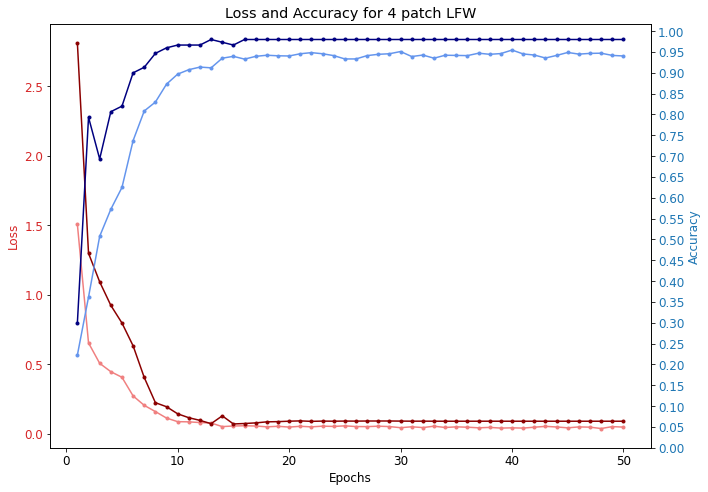

In [ ]:
X = range(1, 51)
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 12})
plt.title('Loss and Accuracy for 4 patch LFW')
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Loss", color=color)
ax1.plot(list(X), tr_loss,'.-', label='train', color = 'lightcoral')
ax1.plot(list(X), vl_loss,'.-', label='validation', color = 'darkred')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(list(X), Acc_tr, '.-', label='train', color = 'cornflowerblue')
ax2.plot(list(X), Acc_vl, '.-', label='validation', color = 'navy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([i/20 for i in range(21) ])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()